In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [1]:
import pandas as pd

# GitHub raw CSV link
url = "https://raw.githubusercontent.com/Stanley2204/TugasDataMining/main/synthetic_coffee_health.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(url)

# Preview the data
print("✅ File successfully loaded from GitHub")
print(df.head())


✅ File successfully loaded from GitHub
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consumption  
0           NaN   

In [4]:
# 1. Print all column names (may contain duplicates)
print("All columns:", df.columns.tolist())

All columns: ['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']


In [15]:
print("=== HEAD ===")
print(df.head())
print("\n=== INFO ===")
print(df.info())
print("\n=== DESCRIBE (numerical) ===")
print(df.describe(include=[np.number]).T)
print("\n=== DESCRIBE (object) ===")
print(df.describe(include=['object']).T)

target_col = 'Health_Issues'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Adjust target_col variable.")

df[target_col] = df[target_col].fillna("Missing").astype(str)

print("\nTarget value counts:")
print(df[target_col].value_counts())


=== HEAD ===
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consumption  
0           NaN      Other        0         

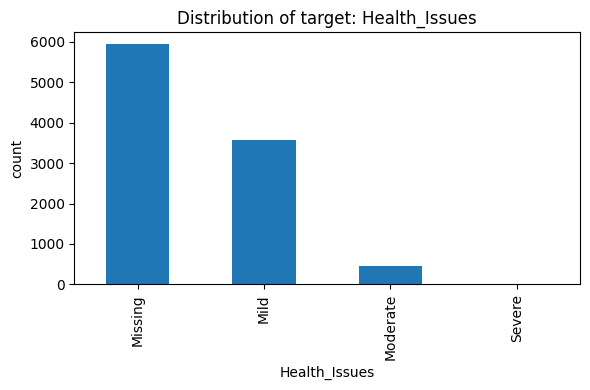

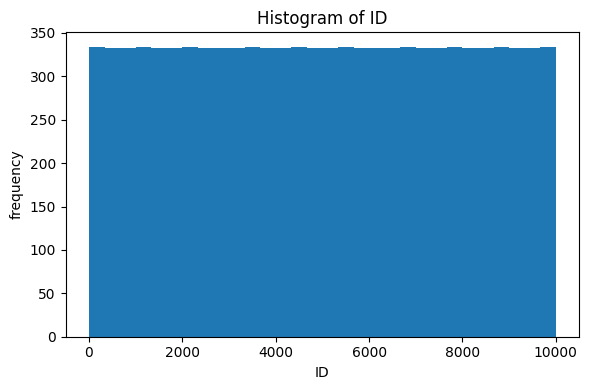

<Figure size 600x400 with 0 Axes>

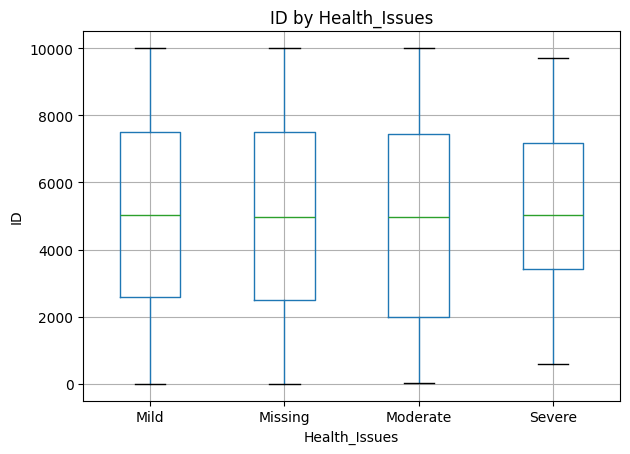

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)

# Visualization 1: Target distribution
plt.figure(figsize=(6,4))
df[target_col].value_counts().plot(kind='bar')
plt.title("Distribution of target: Health_Issues")
plt.xlabel("Health_Issues")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Visualization 2: Histogram of first numeric col
if numeric_cols:
    col = numeric_cols[0]
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()

# Visualization 3: Boxplot numeric vs target
if numeric_cols:
    col = numeric_cols[0]
    plt.figure(figsize=(6,4))
    df.boxplot(column=col, by=target_col)
    plt.title(f"{col} by {target_col}")
    plt.suptitle("")
    plt.xlabel(target_col)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# fallback categorical visualization
if not numeric_cols and cat_cols:
    col = cat_cols[0]
    cross = pd.crosstab(df[col], df[target_col], normalize='index')
    cross.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f"Proportion of {target_col} by {col}")
    plt.tight_layout()
    plt.show()

In [17]:
X = df.drop(columns=[target_col])
y = df[target_col].copy()

le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)
target_names = [str(x) for x in le_target.classes_]

print("\nTarget classes mapping:")
print(dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

cat_features = X.select_dtypes(include=['object','category']).columns.tolist()
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
print("\nCategorical features:", cat_features)
print("Numerical features:", num_features)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ],
    remainder="drop"
)


Target classes mapping:
{'Mild': np.int64(0), 'Missing': np.int64(1), 'Moderate': np.int64(2), 'Severe': np.int64(3)}

Categorical features: ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation']
Numerical features: ['ID', 'Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 'Alcohol_Consumption']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

def build_pipeline(model):
    return Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", model)
    ])


Train shape: (8000, 15), Test shape: (2000, 15)


In [19]:
dt_entropy = build_pipeline(DecisionTreeClassifier(criterion="entropy", random_state=42))
dt_entropy.fit(X_train, y_train)
y_pred_dt_entropy = dt_entropy.predict(X_test)
acc_dt_entropy = accuracy_score(y_test, y_pred_dt_entropy)
print("\nDecision Tree (entropy) Accuracy:", acc_dt_entropy)
print("Classification Report (entropy):")
print(classification_report(y_test, y_pred_dt_entropy, target_names=target_names))



Decision Tree (entropy) Accuracy: 0.998
Classification Report (entropy):
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       716
     Missing       1.00      1.00      1.00      1188
    Moderate       1.00      0.99      0.99        93
      Severe       1.00      1.00      1.00         3

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [20]:
dt_gini = build_pipeline(DecisionTreeClassifier(criterion="gini", random_state=42))
dt_gini.fit(X_train, y_train)
y_pred_dt_gini = dt_gini.predict(X_test)
acc_dt_gini = accuracy_score(y_test, y_pred_dt_gini)
print("\nDecision Tree (gini) Accuracy:", acc_dt_gini)
print("Classification Report (gini):")
print(classification_report(y_test, y_pred_dt_gini, target_names=target_names))


Decision Tree (gini) Accuracy: 0.998
Classification Report (gini):
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       716
     Missing       1.00      1.00      1.00      1188
    Moderate       1.00      0.99      0.99        93
      Severe       1.00      1.00      1.00         3

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [21]:
gnb = build_pipeline(GaussianNB())
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
acc_gnb = accuracy_score(y_test, y_pred_gnb)
print("\nGaussianNB Accuracy:", acc_gnb)
print("Classification Report (GaussianNB):")
print(classification_report(y_test, y_pred_gnb, target_names=target_names))


GaussianNB Accuracy: 0.699
Classification Report (GaussianNB):
              precision    recall  f1-score   support

        Mild       0.94      0.23      0.38       716
     Missing       0.85      1.00      0.92      1188
    Moderate       0.18      0.44      0.26        93
      Severe       0.00      0.33      0.01         3

    accuracy                           0.70      2000
   macro avg       0.49      0.50      0.39      2000
weighted avg       0.85      0.70      0.69      2000



In [22]:
print("\n=== Accuracy comparison ===")
print(f"DecisionTree (entropy): {acc_dt_entropy:.4f}")
print(f"DecisionTree (gini):    {acc_dt_gini:.4f}")
print(f"GaussianNB:             {acc_gnb:.4f}")

best_name = max(
    [("DT_entropy", acc_dt_entropy), ("DT_gini", acc_dt_gini), ("GNB", acc_gnb)],
    key=lambda x: x[1]
)[0]
print(f"\nBest model by accuracy: {best_name}")

best_model = {"DT_entropy": dt_entropy, "DT_gini": dt_gini, "GNB": gnb}[best_name]


=== Accuracy comparison ===
DecisionTree (entropy): 0.9980
DecisionTree (gini):    0.9980
GaussianNB:             0.6990

Best model by accuracy: DT_entropy


In [23]:
sample = {}
for col in X.columns:
    if col in num_features:
        sample[col] = float(X[col].median())
    else:
        sample[col] = X[col].mode().iloc[0] if not X[col].mode().empty else ""

print("\nExample new record (auto-generated from median/mode):")
print(sample)

new_df = pd.DataFrame([sample])


Example new record (auto-generated from median/mode):
{'ID': 5000.5, 'Age': 34.0, 'Gender': 'Female', 'Country': 'Canada', 'Coffee_Intake': 2.5, 'Caffeine_mg': 235.4, 'Sleep_Hours': 6.6, 'Sleep_Quality': 'Good', 'BMI': 24.0, 'Heart_Rate': 71.0, 'Stress_Level': 'Low', 'Physical_Activity_Hours': 7.5, 'Occupation': 'Office', 'Smoking': 0.0, 'Alcohol_Consumption': 0.0}


In [24]:
pred_enc = best_model.predict(new_df)
pred_label = le_target.inverse_transform(pred_enc)
print("\nPredicted encoded label:", pred_enc)
print("Predicted class (Health_Issues):", pred_label[0])

if hasattr(best_model.named_steps['clf'], "predict_proba"):
    probs = best_model.predict_proba(new_df)
    print("\nPredicted probabilities for each class:")
    print(pd.DataFrame(probs, columns=le_target.classes_))



Predicted encoded label: [1]
Predicted class (Health_Issues): Missing

Predicted probabilities for each class:
   Mild  Missing  Moderate  Severe
0   0.0      1.0       0.0     0.0
